In [ ]:
fvalidation_set_size = 1024
BATCH_SIZE = 1024
IMAGE_SIZE = 128
NUMBER_OF_PARTICLES = 1 #number of extra particles in image will be round(poi(NUMBER_OF_PARTICLES))
Z_RANGE = 30
NEW_MODELS=1
save_model_path = "/content/drive/My Drive/imag_n_real_feb22/"
models_path = "/content/drive/My Drive/imag_n_real_feb21/"

In [ ]:
"""Import everything we need and check gpu"""
%matplotlib inline

already_installed = !pip list -v | grep deeptrack
if not already_installed:
    !pip install deeptrack==0.11.3

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt
import tensorflow.keras as keras

from matplotlib import colors
from cycler import cycler
from google.colab import drive
from tensorflow.keras import layers, models
from tensorflow.math import abs, angle, real, imag

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)    
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 22 13:10:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def save_models(models):
    drive.mount('/content/drive')
    for i, model in enumerate(models):
        model.save(save_model_path+f"model{i}")

def load_models(path, NUMBER_OF_MODELS):
    """Load models and return them in a list"""
    drive.mount('/content/drive')
    return [models.load_model(path+f"/model{i}") for i in range(NUMBER_OF_MODELS)]

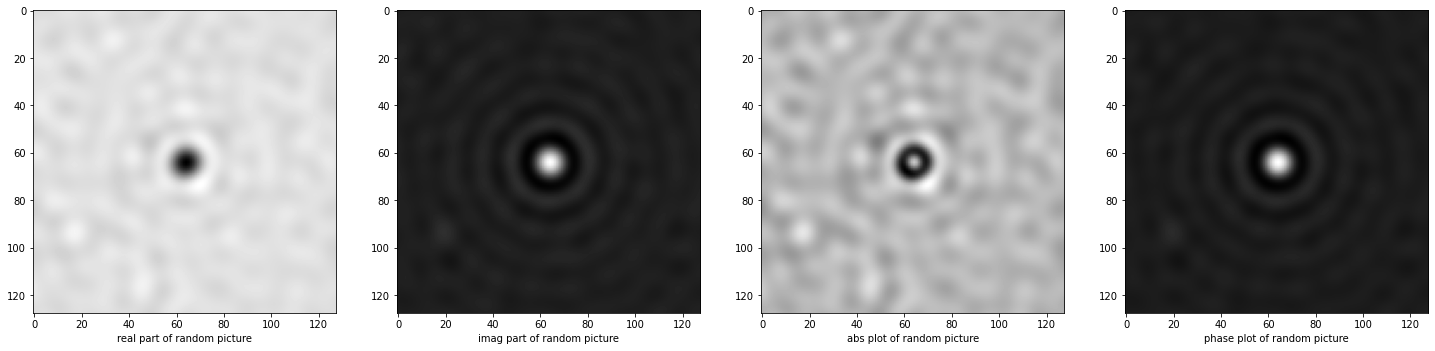

In [ ]:
"""Define optics"""

particle_middle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE//2, IMAGE_SIZE//2),
    z=lambda: -Z_RANGE//2 + np.random.random() * Z_RANGE,
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)


particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE) * np.random.rand(2),
    z=lambda: -(300+Z_RANGE//2)//2 + np.random.random()*(300+Z_RANGE//2),
    radius=lambda: 1.5e-7 + 3e-7 * np.random.rand() ,
    refractive_index=lambda: np.random.uniform(0, 0.15) + 1.45,
    L=8,
    position_unit="pixel",
)

def crop(pupil_radius):
    def inner(image):
        x = np.arange(image.shape[0]) - image.shape[0] / 2
        y = np.arange(image.shape[1]) - image.shape[1] / 2
        X, Y = np.meshgrid(x, y)
        image[X ** 2 + Y ** 2 > pupil_radius ** 2] = 0
        return image
    return inner

HC = dt.HorizontalComa(coefficient=lambda c1: c1, c1=0 + np.random.randn() * 0.05)
VC = dt.VerticalComa(coefficient=lambda c2:c2, c2=0 + np.random.randn() * 0.05)
CROP = dt.Lambda(crop, pupil_radius=IMAGE_SIZE//6)

optics = dt.Brightfield(
    NA=1.3,
    resolution=1.13e-6,
    wavelength=525e-9,
    polarization_angle=lambda: np.random.rand() * 2 * np.pi,
    magnification=10,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    padding=(64,) * 4,
    return_field=True,
    pupil=HC+VC + CROP,
)

real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035 + np.random.rand() * 0.01,
)

noise = real_noise + dt.Gaussian(
    mu=0, 
    sigma=lambda: 0.035j + np.random.rand() * 0.01j,
    real_sigma=real_noise.sigma
)

gradient = dt.IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 5e-5,
)

def normalization_func():
    def inner(image):
        image = image / np.max(np.abs(image))
        return image
    return inner

def nonlinear_pxmapping():
    def inner(image):
        def sq(x):
            return x**1
        return sq(image)
    return inner

normalization = dt.Lambda(normalization_func)
nonlinear = dt.Lambda(nonlinear_pxmapping)

"""Plotting one random image and creating the dataset"""
def particles(particle):
    return particle ** max(0, round(np.random.poisson(lam=NUMBER_OF_PARTICLES)))
                                          
dataset = optics(particle_middle + particles(particle) + noise + gradient) + normalization
dataset = dt.FlipLR(dt.FlipUD(dt.FlipDiagonal(dataset)))
test_image = dataset.update().resolve()[:,:,0]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,8))
ax1.imshow(np.real(test_image), cmap='gray')
ax1.set_xlabel("real part of random picture")
ax2.imshow(np.imag(test_image), cmap='gray')
ax2.set_xlabel("imag part of random picture")
ax3.imshow(np.abs(test_image), cmap='gray')
ax3.set_xlabel("abs plot of random picture")
ax4.imshow(np.angle(test_image), cmap='gray')
ax4.set_xlabel("phase plot of random picture")
plt.show()

In [ ]:
"""get_label returns the z position of the middle particle, but normalized to [0,1]"""
def get_label(image):
    return np.array([image.get_property("z")])

In [ ]:
class CustomLayer(keras.layers.Layer):
    "Takes a complex image as input and outputs 4 real images."

    def __init__(self):
        super().__init__()

    def build( self, input_shape):
            super().build(input_shape)

    def call(self, image):
        return tf.squeeze(tf.stack([abs(image), angle(image), real(image), imag(image)], axis=-1), axis=-2)

"Skapar modeller!"
if True:
    if NEW_MODELS:
        models_to_train = []
        for _ in range(2):
            model = models.Sequential()
            model.add(keras.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
            model.add(CustomLayer())
            model.add(layers.Conv2D(16, 7, activation='relu', strides=(3,3)))
            model.add(layers.Conv2D(32, 7, activation='relu', strides=(3,3)))
            model.add(layers.Flatten())
            model.add(layers.Dense(32, activation='relu'))
            model.add(layers.Dense(1))
            model.compile(optimizer='adam', loss='mae')
            model.totalhistory = {"val_loss":[], "loss":[]}
            model.specs="big"
            model.summary()
            models_to_train.append(model)

    else:
        models_to_train = load_models(models_path, 3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_layer (CustomLayer)  (None, 128, 128, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 25, 25, 16)        3152      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 32)          25120     
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 32)                25632     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 53,937
Trainable params: 53,937
Non-traina

In [ ]:
#@title
"""Helper functions to visualize progress during training."""

def save_progress(h, validation_set, validation_labels, model, plot=True):
    model.totalhistory["val_loss"].extend(h.history["val_loss"])
    model.totalhistory["loss"].extend(h.history["loss"])
                
    if plot:
        validation_predictions = model.predict(np.array(validation_set))
        std = np.std(validation_predictions-np.array(validation_labels))
        mean = np.mean(validation_predictions-np.array(validation_labels))
        model.stats = {"sigma":np.round(std, decimals=3), "mu":np.round(mean, decimals=3)}
        print(model.stats)
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,8))

        ax1.plot(model.totalhistory["val_loss"], 'g', label="validation loss")
        ax1.plot(model.totalhistory["loss"], 'b', label="training loss")
        ax1.set_xlabel("Epoch")
        ax1.set_yscale('log')
        ax1.legend()

        ax2.scatter(np.array(validation_predictions), np.array(validation_labels))
        ax2.plot(np.linspace(-Z_RANGE/2,Z_RANGE/2),np.linspace(-Z_RANGE/2,Z_RANGE/2),'k')
        ax2.set_xlabel("predicted z")
        ax2.set_ylabel("actual z")

        ax3.hist(np.array((validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
        ax3.set_xlabel("Pixlar från faktiskt värde")

        index = np.random.randint(validation_set_size)
        ax4.imshow(np.abs(validation_set[index])[:,:,0], cmap='gray')
        ax4.set_xlabel("abs av slumpmässig bild.")

        plt.show()

def plot_together(models):
    cc = (cycler(color=list('bgrcmykbgrcmykbgrcmykbgrcmyk')) +
      cycler(linestyle=['-','-','-','-','-','-','-','--','--','--','--','--','--','--','-.','-.','-.','-.','-.','-.','-.',':',':',':',':',':',':',':']))
    
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    ax.set_prop_cycle(cc)
    for i, model in enumerate(models):
        ax.plot(moving_average(model.totalhistory["val_loss"], min(100, len(model.totalhistory["val_loss"])//4)), label=f"{model.stats}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Validation loss")
        ax.set_yscale("log")
        ax.legend()

    ax.grid(True)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def print_std(models, n):
    mean_validation_predictions = np.mean([model.predict(np.array(validation_set)) for model in models[:n]], axis=0)
    diffs = np.array((mean_validation_predictions-np.array(validation_labels)))
    print(f"sigma and mu for {n} best models: {np.std(diffs)}, {np.mean(diffs)}")
    plt.hist(np.array((mean_validation_predictions-np.array(validation_labels))), bins=list(np.linspace(-Z_RANGE/2,Z_RANGE/2,10*Z_RANGE)))
    plt.show()

In [ ]:
"""Create the validation set"""
validation_set = [dataset.update().resolve() for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]


In [ ]:
"""Training all the models"""
generator = dt.generators.ContinuousGenerator(
    dataset,
    get_label,
    min_data_size=BATCH_SIZE*5,
    max_data_size=BATCH_SIZE*10,
    batch_size=BATCH_SIZE,
    #max_sample_exposure=1,
)

for _ in range(150):
    with generator:
        for i, model in enumerate(models_to_train):
            h = model.fit(
                generator,
                validation_data=(
                    np.array(validation_set), 
                    np.array(validation_labels)
                ),
                epochs=5,
                verbose=0,
            )
            print(model.specs)
            save_progress(h, validation_set, validation_labels, model, plot=True)
        models_to_train.sort(key=lambda x: x.totalhistory["val_loss"][-1])
        plot_together(models_to_train)
        print_std(models_to_train, 5)

In [ ]:
"""Save models"""
save_models(models_to_train[:15])

In [ ]:
res = []
model = models_to_train[0]

for i in range(50):
    subset = [dataset.update().resolve() for _ in range(8)]
    preds = model.predict_on_batch(np.array(subset))
    actual = subset[0].get_property("z")
    mu = np.mean(preds)
    sigma = np.std(preds)
    #print(f"error: {mu-actual:.2f}, std: {sigma:.2f}")
    plt.scatter(mu-actual, sigma)
plt.show()


In [ ]:
for _ in range(100):
    print(max(0, round(np.random.poisson(lam=0.5))))

In [ ]:
#@title
import keras

def visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8):
    """
        # Parameters:
        model: The keras model whose featuremaps are to be visualized.
        image_of_particles: The image that should be visualized.
        SUBPLOT_SIZE: The size of each individual subplot.
        SUBPLOT_WIDTH: The number of subplots to lign up horizontally. Prefferably a multiple of two.
    """
    # Plotting the two input channels (Im() and Re())
    input_fig, ax = plt.subplots(1, 2)

    ax[0].imshow(image_of_particle[:, :, 0], cmap='gray')
    ax[0].set_title("Real (?) part")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(image_of_particle[:, :, 1], cmap='gray')
    ax[1].set_title("Im (?) part")
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    plt.show()

    # Plotting all outputs from convolutional layer, each layer is given its own figure
    IMAGE_SIZE = image_of_particle.shape[0]
    img = image_of_particle.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 2) # Reshape needed for model prediction input

    for layer in model.layers:
        if 'conv' not in layer.name: # Ignoring non-convolutional layers
            continue
        
        NUMBER_OF_OUTPUTS = layer.output.shape[3] # Total number of subplots
        SUBPLOT_HEIGHT = NUMBER_OF_OUTPUTS // SUBPLOT_WIDTH # Number of rows needed

        # Create a submodel equal to the original model but cut off at the current layer.
        submodel = keras.Model(inputs=model.inputs, outputs=layer.output)

        # Generate prediction outputs for the submodel
        feature_maps = submodel.predict(img)

        # Plotting all the outputs in a square figure

        output_number = 0
        fig, ax = plt.subplots(SUBPLOT_HEIGHT, SUBPLOT_WIDTH, figsize=(SUBPLOT_WIDTH * SUBPLOT_SIZE, SUBPLOT_HEIGHT * SUBPLOT_SIZE))
        fig.suptitle("Output of layer: " + layer.name)
        ax = ax.flatten()

        for output_number, axis in zip(range(len(ax)), ax):
            axis.imshow(feature_maps[0, :, :, output_number], cmap='gray')
            ax[output_number].set_xticks([])
            ax[output_number].set_yticks([])
                
        plt.show()

model=models[0]
image_of_particle=validation_set[0]
visualize_feature_maps(model, image_of_particle, SUBPLOT_SIZE=6, SUBPLOT_WIDTH=8)